In [38]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init

import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('/Users/ponynie/Developer/Python_Code/IntroDMLabChula/Final_Project/children anemia.csv')
data.drop('Anemia level.1', axis=1, inplace=True)
data.dropna(subset=['Anemia level','When child put to breast','Had fever in last two weeks','Taking iron pills, sprinkles or syrup'],inplace=True)
data['Currently residing with husband/partner'] = data['Currently residing with husband/partner'].fillna(data['Currently residing with husband/partner'].median)
data['Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)'] = data['Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)'].fillna(data['Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)'].mean)
data['Age in 5-year groups'] = data['Age in 5-year groups'].apply(lambda x: sum(map(int,x.split('-')))/2)
data.drop(columns=['When child put to breast', 'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)'],inplace=True)
data = data[data['Currently residing with husband/partner'].isin(['Living with her', 'Staying elsewhere'])]
data = data[data['Had fever in last two weeks'].isin(['No', 'Yes'])]
data = data[data['Taking iron pills, sprinkles or syrup'].isin(['No', 'Yes'])]

data.head(10)

,Age in 5-year groups,Type of place of residence,Highest educational level,Wealth index combined,Births in last five years,Age of respondent at 1st birth,Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal),Anemia level,Have mosquito bed net for sleeping (from household questionnaire),Smokes cigarettes,Current marital status,Currently residing with husband/partner,Had fever in last two weeks,"Taking iron pills, sprinkles or syrup"
3,27.0,Urban,Secondary,Richest,1,25,95.0,Moderate,Yes,No,Married,Living with her,No,No
6,37.0,Urban,Secondary,Richest,2,32,121.0,Not anemic,Yes,No,Married,Living with her,No,Yes
9,22.0,Urban,Secondary,Richest,1,19,108.0,Moderate,Yes,No,Married,Living with her,No,Yes
12,27.0,Urban,Higher,Richest,1,24,116.0,Mild,Yes,No,Married,Living with her,No,No
13,22.0,Urban,Higher,Richest,2,19,118.0,Mild,Yes,No,Married,Living with her,No,Yes
16,27.0,Urban,Higher,Richest,2,22,134.0,Not anemic,Yes,No,Married,Living with her,No,No
18,27.0,Urban,Secondary,Richest,2,22,95.0,Moderate,Yes,No,Married,Living with her,No,Yes
21,27.0,Urban,Secondary,Richer,1,23,109.0,Mild,Yes,No,Married,Living with her,No,No
22,27.0,Urban,Secondary,Richer,2,20,101.0,Mild,Yes,No,Married,Living with her,No,Yes
25,27.0,Urban,Secondary,Richer,2,20,129.0,Not anemic,Yes,No,Married,Staying elsewhere,No,No


In [39]:
categorical_columns = ['Current marital status', 'Type of place of residence', 'Highest educational level', 'Wealth index combined', 'Have mosquito bed net for sleeping (from household questionnaire)', 'Smokes cigarettes', 'Currently residing with husband/partner', 'Had fever in last two weeks', 'Taking iron pills, sprinkles or syrup']
numerical_columns = ['Age in 5-year groups', 'Births in last five years', 'Age of respondent at 1st birth', 'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)']
label_columns = 'Anemia level'

for category in categorical_columns:
    data[category] = data[category].astype('category')
data['Anemia level'] = data['Anemia level'].astype('category')

for categorical in categorical_columns:
    print(data[categorical].cat.categories, categorical)
print(data['Anemia level'].cat.categories, "Label")

Index(['Living with partner', 'Married'], dtype='object') Current marital status
Index(['Rural', 'Urban'], dtype='object') Type of place of residence
Index(['Higher', 'No education', 'Primary', 'Secondary'], dtype='object') Highest educational level
Index(['Middle', 'Poorer', 'Poorest', 'Richer', 'Richest'], dtype='object') Wealth index combined
Index(['No', 'Yes'], dtype='object') Have mosquito bed net for sleeping (from household questionnaire)
Index(['No', 'Yes'], dtype='object') Smokes cigarettes
Index(['Living with her', 'Staying elsewhere'], dtype='object') Currently residing with husband/partner
Index(['No', 'Yes'], dtype='object') Had fever in last two weeks
Index(['No', 'Yes'], dtype='object') Taking iron pills, sprinkles or syrup
Index(['Mild', 'Moderate', 'Not anemic', 'Severe'], dtype='object') Label


In [40]:
categorical_np = [data[i].cat.codes.values for i in categorical_columns]
categorical_data = np.stack(categorical_np, 1)
categorical_data[:10]

array([[1, 1, 3, 4, 1, 0, 0, 0, 0],
       [1, 1, 3, 4, 1, 0, 0, 0, 1],
       [1, 1, 3, 4, 1, 0, 0, 0, 1],
       [1, 1, 0, 4, 1, 0, 0, 0, 0],
       [1, 1, 0, 4, 1, 0, 0, 0, 1],
       [1, 1, 0, 4, 1, 0, 0, 0, 0],
       [1, 1, 3, 4, 1, 0, 0, 0, 1],
       [1, 1, 3, 3, 1, 0, 0, 0, 0],
       [1, 1, 3, 3, 1, 0, 0, 0, 1],
       [1, 1, 3, 3, 1, 0, 1, 0, 0]], dtype=int8)

In [41]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[1, 1, 3, 4, 1, 0, 0, 0, 0],
        [1, 1, 3, 4, 1, 0, 0, 0, 1],
        [1, 1, 3, 4, 1, 0, 0, 0, 1],
        [1, 1, 0, 4, 1, 0, 0, 0, 0],
        [1, 1, 0, 4, 1, 0, 0, 0, 1],
        [1, 1, 0, 4, 1, 0, 0, 0, 0],
        [1, 1, 3, 4, 1, 0, 0, 0, 1],
        [1, 1, 3, 3, 1, 0, 0, 0, 0],
        [1, 1, 3, 3, 1, 0, 0, 0, 1],
        [1, 1, 3, 3, 1, 0, 1, 0, 0]])

In [42]:
numerical_data = np.stack([data[i].values for i in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:10]

tensor([[ 27.,   1.,  25.,  95.],
        [ 37.,   2.,  32., 121.],
        [ 22.,   1.,  19., 108.],
        [ 27.,   1.,  24., 116.],
        [ 22.,   2.,  19., 118.],
        [ 27.,   2.,  22., 134.],
        [ 27.,   2.,  22.,  95.],
        [ 27.,   1.,  23., 109.],
        [ 27.,   2.,  20., 101.],
        [ 27.,   2.,  20., 129.]])

In [43]:
outputs = torch.tensor(data['Anemia level'].cat.codes.values).flatten()
outputs[:10]

tensor([1, 2, 1, 0, 0, 2, 1, 0, 0, 2], dtype=torch.int8)

In [44]:
categorical_data.shape, numerical_data.shape, outputs.shape

(torch.Size([7237, 9]), torch.Size([7237, 4]), torch.Size([7237]))

In [45]:
categorical_column_sizes = [len(data[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(2, 1), (2, 1), (4, 2), (5, 3), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1)]


In [46]:
total_records = data.shape[0]
test_records = int(total_records * .2) # 20% of the data for testing
train_records = total_records - test_records # 80% of the data for training

categorical_train_data = categorical_data[:train_records]
categorical_test_data = categorical_data[train_records:]
numerical_train_data = numerical_data[:train_records]
numerical_test_data = numerical_data[train_records:]
train_label = outputs[:train_records]
test_label = outputs[train_records:]

print(categorical_train_data.shape, categorical_test_data.shape)
print(numerical_train_data.shape, numerical_test_data.shape)
print(train_label.shape, test_label.shape)

torch.Size([5790, 9]) torch.Size([1447, 9])
torch.Size([5790, 4]) torch.Size([1447, 4])
torch.Size([5790]) torch.Size([1447])


In [47]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [48]:
hidden_layers = [200,100,50]
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 4, hidden_layers, p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-1): 2 x Embedding(2, 1)
    (2): Embedding(4, 2)
    (3): Embedding(5, 3)
    (4-8): 5 x Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Lin

In [49]:
if torch.backends.mps.is_available():
    print ("MPS device found.")
else:
    print("MPS device not found.")

mps_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model.to(mps_device)
categorical_train_data = categorical_train_data.to(mps_device)
numerical_train_data = numerical_train_data.to(mps_device)
categorical_test_data = categorical_test_data.to(mps_device)
numerical_test_data = numerical_test_data.to(mps_device)
train_label = train_label.to(mps_device)
test_label = test_label.to(mps_device)  

MPS device found.


In [50]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 300

epoch:   1 loss: 1.60735273


epoch:  26 loss: 0.75983775
epoch:  51 loss: 0.53274035
epoch:  76 loss: 0.46750358
epoch: 101 loss: 0.44574672
epoch: 126 loss: 0.40624672
epoch: 151 loss: 0.38794848
epoch: 176 loss: 0.37336656
epoch: 201 loss: 0.36317912
epoch: 226 loss: 0.35151145
epoch: 251 loss: 0.33534348
epoch: 276 loss: 0.33503383
epoch: 300 loss: 0.3271248341


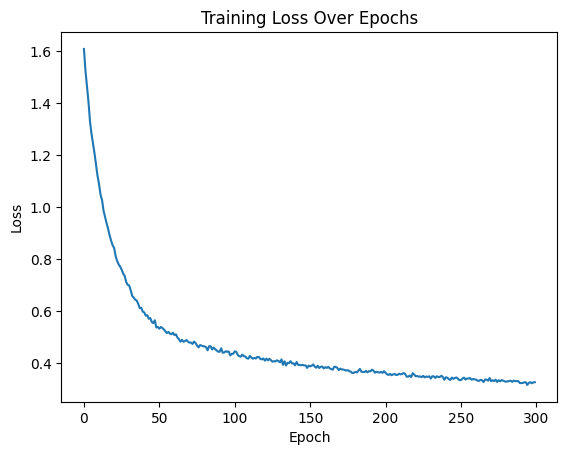

In [51]:
aggregated_losses = []

for i in range(epochs):
    i += 1
    pred = model(categorical_train_data, numerical_train_data)
    single_loss = loss_function(pred, train_label)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

aggregated_losses_on_cpu = [tensor.detach().cpu() for tensor in aggregated_losses]
plt.plot(range(epochs), aggregated_losses_on_cpu)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [52]:
with torch.no_grad():
    eval = model(categorical_test_data, numerical_test_data)
    loss = loss_function(eval, test_label)
print(f'Loss: {loss:.8f}')

Loss: 0.43665671


In [53]:
print(eval[:5])
eval = np.argmax(eval.detach().cpu(), axis=1)
print(eval[:5])

tensor([[-0.5970,  3.3351, -4.3911,  1.5635],
        [ 2.0436,  2.5300, -1.9666, -1.4973],
        [-0.7115,  6.0480, -8.4216,  3.7325],
        [ 1.9559,  2.6752, -1.9457, -1.7800],
        [ 1.8873,  3.4415, -2.4777, -0.4904]], device='mps:0')
tensor([1, 1, 1, 1, 1])


In [54]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
test_label = test_label.detach().cpu()
print(confusion_matrix(test_label,eval))
print("--------------------------------------------------------------------------------")
print(classification_report(test_label,eval))
print("--------------------------------------------------------------------------------")
print(f"accuracy: {accuracy_score(test_label, eval)*100} %")

[[264 123   2   0]
 [  2 364   0   3]
 [103  12 557   0]
 [  0   7   0  10]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       389
           1       0.72      0.99      0.83       369
           2       1.00      0.83      0.90       672
           3       0.77      0.59      0.67        17

    accuracy                           0.83      1447
   macro avg       0.80      0.77      0.78      1447
weighted avg       0.85      0.83      0.83      1447

--------------------------------------------------------------------------------
accuracy: 82.58465791292329 %
